In [1]:
import os
import torch
from PIL import Image
from torch.utils.data import Dataset

num_batch_size=100

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = [file for file in os.listdir(self.root_dir) if file.endswith('.jpg')]

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.file_list[index])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.file_list)

from torch.utils.data import DataLoader
from torchvision import transforms

root_dir = "../images"
transform = transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()])

image_dataset = CustomImageDataset(root_dir=root_dir, transform=transform)
image_loader = DataLoader(image_dataset, batch_size=num_batch_size, shuffle=True, num_workers=0)

In [2]:
import itertools
import math
import time
import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from IPython import display
from torch.autograd import Variable
import torch.nn.functional as F

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64 * 12 * 12, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.model(x).reshape(-1)

class Deflatten(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x.reshape(-1, 32, 25, 25)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64 * 12 * 12, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 32 * 25 * 25),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            Deflatten(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1), 
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [3]:
discriminator = Discriminator().cuda()
generator = Generator().cuda()
generator.load_state_dict(torch.load('../weight/generator.pth'))
discriminator.load_state_dict(torch.load('../weight/discriminator.pth'))
lr = 0.0002
num_epochs = 1000
num_batches = len(image_loader)
num_test_samples = 16
c = 0.1
test_noise = Variable(torch.randn(num_test_samples,3, 100, 100).cuda())
d_optimizer = torch.optim.RMSprop(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.RMSprop(generator.parameters(), lr=lr)
def train_discriminator(discriminator, images, fake_images):
    discriminator.zero_grad()
    real_outputs = discriminator(images)
    real_score = real_outputs
    fake_outputs = discriminator(fake_images)
    fake_score = fake_outputs
    d_loss = -(torch.mean(real_outputs) - torch.mean(fake_outputs))
    d_loss.backward()
    d_optimizer.step()
    for p in discriminator.parameters():
        p.data.clamp_(-c, c)
    return d_loss, real_score, fake_score
def train_generator(generator, discriminator_outputs):
    generator.zero_grad()
    g_loss = -torch.mean(discriminator_outputs)
    g_loss.backward()
    g_optimizer.step()
    return g_loss

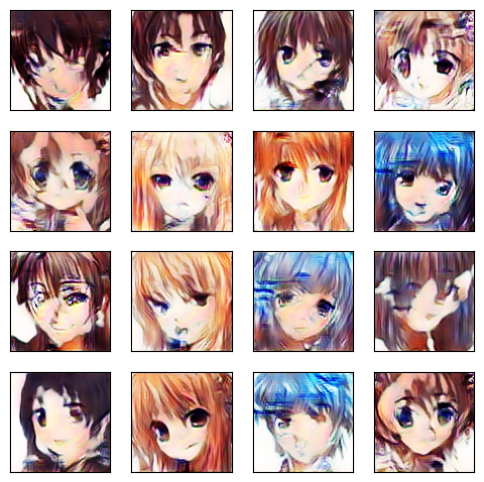

Epoch [13/2000], Step[800/1066], d_loss: -2407.7773, g_loss: -14509.0947, D(x): 18095.23, D(G(z)): 15687.45


In [ ]:
# create figure for plotting
num_epochs=2000
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i, j].get_xaxis().set_visible(False)
    ax[i, j].get_yaxis().set_visible(False)
num_fig = 0

for epoch in range(num_epochs):
    for n, (images) in enumerate(image_loader):
        images = Variable(images.cuda())
        # Sample from generator
        noise = Variable(torch.randn(images.size(0),3,100,100).cuda())
        fake_images = generator(noise)
        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(discriminator,images,fake_images)
        # Sample again from the generator and get output from discriminator
        noise = Variable(torch.randn(images.size(0),3,100,100).cuda())
        fake_images = generator(noise)
        outputs = discriminator(fake_images)
        # Train the generator
        g_loss = train_generator(generator, outputs)
        if (n + 1) % 100 == 0:
            test_images = generator(test_noise)
            for k in range(num_test_samples):
                i = k // 4
                j = k % 4
                ax[i, j].cla()
                ax[i, j].imshow(test_images[k, :].data.cpu().permute(1,2,0))
            display.clear_output(wait=True)
            display.display(plt.gcf())
            #plt.savefig('results/anime-gan-%03d.png' % num_fig)
            num_fig += 1
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f, '
                  'D(x): %.2f, D(G(z)): %.2f'
                  % (epoch + 1, num_epochs, n + 1, num_batches, d_loss.data, g_loss.data,
                     real_score.data.mean(), fake_score.data.mean()))
    torch.save(generator.state_dict(),'../weight/generator.pth')
    torch.save(discriminator.state_dict(),'../weight/discriminator.pth')
fig.close()

In [ ]:
torch.save(generator.state_dict(),'/root/generator1_new.pth')
torch.save(discriminator.state_dict(),'/root/discriminator1_new.pth')